In [8]:
import sys
import torch
from matplotlib import pyplot as plt

import os

dir_path = os.getcwd()
dir_path = os.path.dirname(dir_path)

sys.path.append(dir_path)

from a3c.ActorCritic import ActorCritic
from dark_room import DarkRoom
from gpt.GPT import GPT

In [15]:
env = DarkRoom(size=19)
input_dim = env.observation_space.shape[0]
action_space = env.action_space.n


def render_env(env):
    plt.imshow(env.render())
    plt.axis("off")
    plt.show()

In [10]:
a3c = ActorCritic(input_dim, action_space)
# load the model
a3c.load_state_dict(torch.load("../models/a3c_model.pth", weights_only=False))

<All keys matched successfully>

In [14]:
def a3c_step(state):
    policy, _ = a3c(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
    action = torch.softmax(policy, dim=-1).argmax().item()
    return action


state = env.reset()

Goal reached


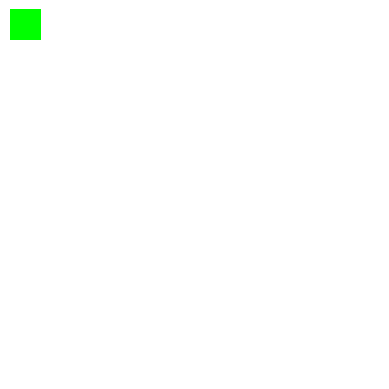

In [27]:
action = a3c_step(state)
state, reward, done = env.step(action)
render_env(env)

In [39]:
gpt = GPT()
gpt.load_state_dict(torch.load("../models/gpt_model.pth", weights_only=False))

<All keys matched successfully>

In [4]:
context = []
returns = []
num_episodes = 100

for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_return = 0
    while not done:
        action = a3c.act(state)
        state, reward, done, _ = env.step(action)
        total_return += reward
        context.append(state)
    returns.append(total_return)

In [ ]:
def evaluate_ad_model(model, env, num_episodes=1000, context_size=200):

    for episode in range(num_episodes):
        obs = env.reset()  # Reset environment, but don't clear context
        episode_return = 0

        for step in range(50):  # 50 steps per episode
            if len(context) >= context_size:
                context = context[-context_size:]

            action = model.predict(context + [obs])
            next_obs, reward, done, _ = env.step(action)

            context.append((obs, action, reward))
            episode_return += reward
            obs = next_obs

            if done:
                break

        returns.append(episode_return)

    return returns

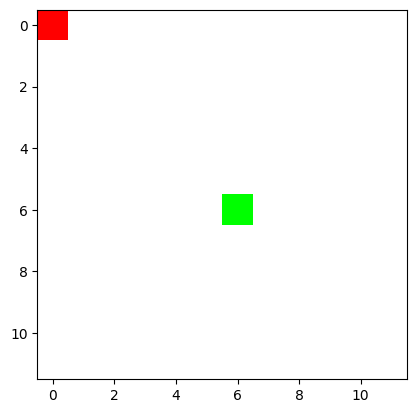

In [7]:
grid_to_render = env.render()


plt.imshow(grid_to_render)
plt.show()